## 求Ackley函数（二元为例）最优解

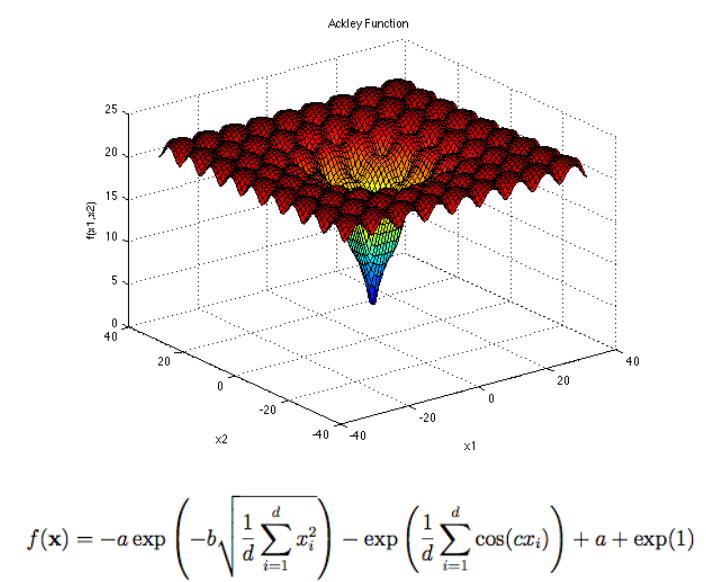

In [ ]:
def F(x, y):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = 2
    sum_sq_term = -a * np.exp(-b * np.sqrt((x * x + y * y) / d))
    cos_term = -np.exp((np.cos(c * x) + np.cos(c * y)) / d)
    z = a + np.exp(1) + sum_sq_term + cos_term
    return z

## 遗传算法基本步骤

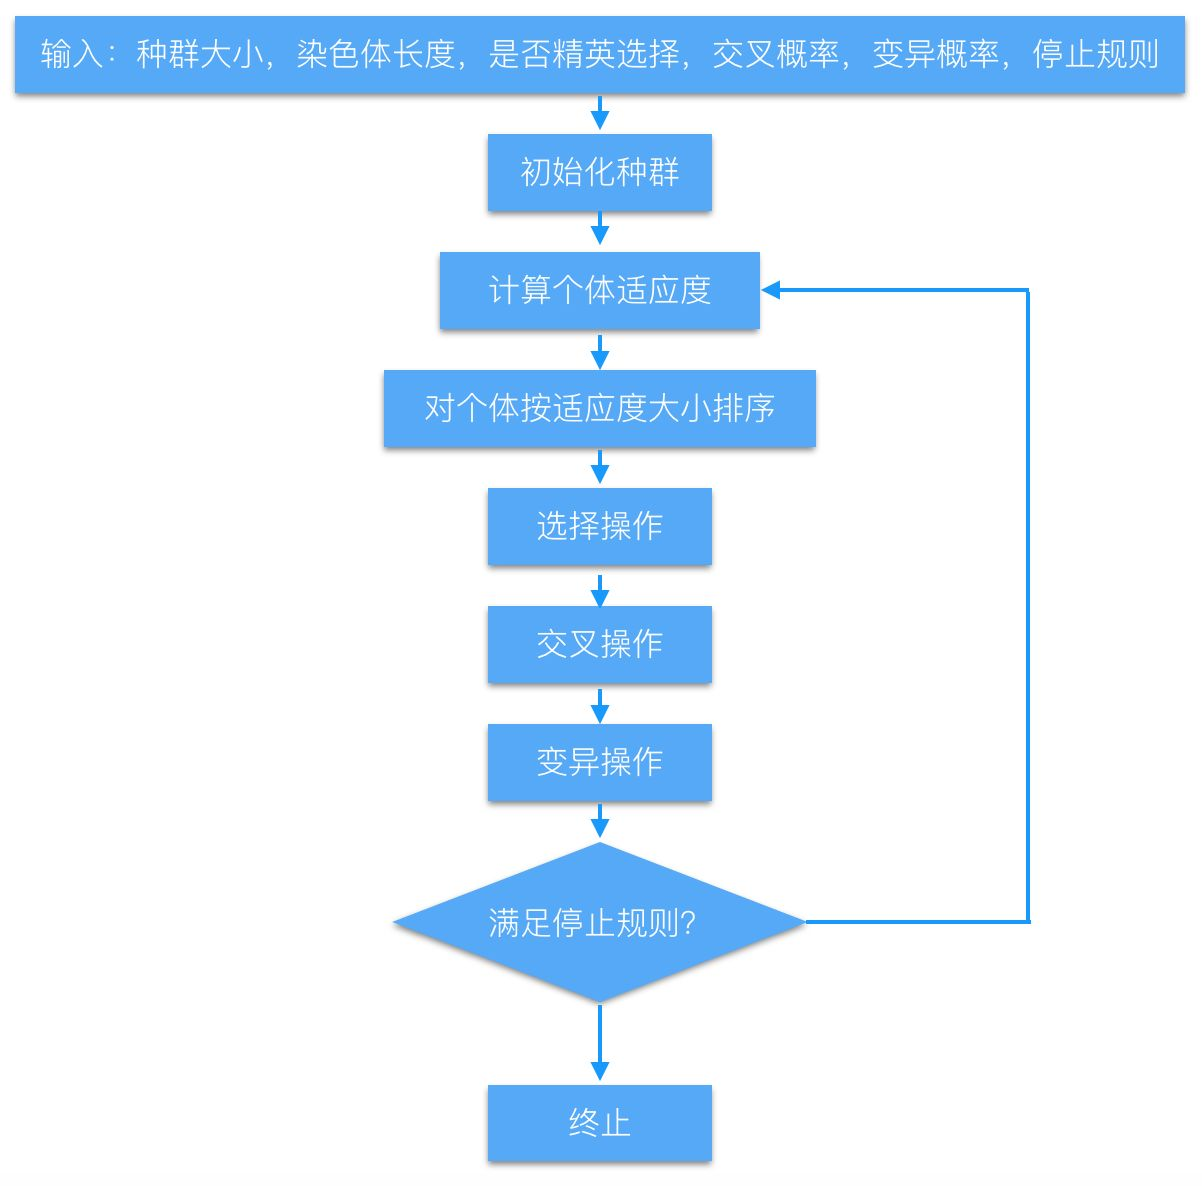
<!-- <img src="mind.jpg" style="width: 300px;"/> -->

### 遗传算法基本原理

在问题最优求解中，我们可能会遇到问题不容易求解的情况，或者不存在凹凸性的情况，或者采用暴力求解不可行如NP问题等。这时候一种思路是采用遗传算法。所谓遗传算法（Genetic Algorithm，GA）是模拟达尔文生物进化论的自然选择和遗传学机理的生物进化过程的计算模型，是通过自然进化过程搜索最优解的方法。遗传算法中非常重要的一个概念就是我们在生物课学习的基因。在最优化问题求解的中，解就是基因序列。

### 遗传算法的使用范围

- 优化问题
-  组合优化问题
- 机器人运动选择问题
- 特征选择

### 编码

首先要对问题的潜在解进行数字化编码，编码的方式可以有二进制编码、浮点编码、符合编码等。他们各有优劣，根据问题需要来原则。一般而言，二进制使用较多。

In [ ]:
def translateDNA(pop):  # pop表示种群矩阵，一行表示一个二进制编码表示的DNA，矩阵的行数为种群数目
    x_pop = pop[:, 1::2]  # 二进制中的奇数列表示X
    y_pop = pop[:, ::2]  # 二进制中的偶数列表示y
    # print(x_pop.shape)
    x = x_pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / float(2 ** DNA_SIZE - 1) * (X_BOUND[1] - X_BOUND[0]) + X_BOUND[0]
    y = y_pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / float(2 ** DNA_SIZE - 1) * (Y_BOUND[1] - Y_BOUND[0]) + Y_BOUND[0]
    return x, y
#将矩阵中的二进制DNA归一化为[-32,32]范围内的实数

### 定义种群大小并初始化

种群中应包含一定数目的染色体。多个染色体构成一个种群
例如矩阵shape是100x48
则种群中有100个染色体（个体）
单个染色体长度是48（二进制字符长度）

In [ ]:
DNA_SIZE=24 #一条dna（解的二进制）的长度
POP_SIZE=100#种群（解空间）的大小
CROSSOVER_RATE = 0.6#交叉概率
MUTATION_RATE = 0.005#变异概率
N_GENERATIONS = 100#迭代次数
X_BOUND = [-32, 32]#解一的范围
Y_BOUND = [-32, 32]#解二的范围

pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE * 2))  # matrix (POP_SIZE, DNA_SIZE)#产生固定shape的随机矩阵
#随机定义初始种群

### 适应度函数

适应度还是就是我们的优化目标，我们把种群里的每个个体带入到适应度函数里就可以得到个体的适应度。在这里，对编码过的基因需要解码然后带入到目标函数。若优化目标是求最大值，那么带入函数计算，结果越大代表适应度越强。

In [ ]:
def get_fitness(pop):#适应度（误差）函数，pop是种群
    x, y = translateDNA(pop)
    pred = F(x, y)
    # 减去最小的适应度是为了防止适应度出现负数，通过这一步fitness的范围为[0, np.max(pred)-np.min(pred)],
    # 最后在加上一个很小的数防止出现为0的适应度
    return -(pred - np.max(pred)) + 1e-3

#适应度越大则种群越优

### 选择进化

自然选择方法有很多，包括轮盘赌选择，随机竞争选择，最佳保留选择，确定式选择等。这里简单介绍一下轮盘赌选择。
具体步骤如下：
(1)首先计算出所有个体的适应度总和Σfi。
(2)其次计算出每个个体的相对适应度大小fi/Σfi，类似于softmax。
(3)再产生一个0到1之间的随机数，依据随机数出现在上述哪个概率区域内来确定各个个体被选中的次数。


In [ ]:
#使用轮盘选择的方式来选择新种群
def select(pop, fitness):
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,p=(fitness) / (fitness.sum()))
    #choice里的最后一个参数p，参数p描述了从np.arange(POP_SIZE)里选择每一个元素的概率，概率越高约有可能被选中，最后返回被选中的个体即可。
    return pop[idx]


### 交叉和变异

经过选择进化过后的个体开始交叉繁衍。过程实际上是染色体基因相互交叉的过程，这里可以设定参数交叉率，来确定对交叉的选择。
(1)先对群体随机配对。
(2)再随机设定交叉点的位置。
(3)再互换配对染色体间的部分基因

变异
设定另外一个参数“变异率”，通过修改染色体上随机位置的一个基因实现变异。

In [ ]:
def crossover_and_mutation(pop, CROSSOVER_RATE=0.8):#交叉和变异，交叉概率是0.8
    new_pop = []
    for father in pop:  # 遍历种群中的每一个个体，将该个体作为父亲
        child = father  # 孩子先得到父亲的全部基因（这里我把一串二进制串的那些0，1称为基因）
        if np.random.rand() < CROSSOVER_RATE:  # 产生子代时不是必然发生交叉，而是以一定的概率发生交叉
            mother = pop[np.random.randint(POP_SIZE)]  # 再种群中选择另一个个体，并将该个体作为母亲
            cross_points = np.random.randint(low=0, high=DNA_SIZE * 2)  # 随机产生交叉的点
            child[cross_points:] = mother[cross_points:]  # 孩子得到位于交叉点后的母亲的基因
        mutation(child)  # 每个后代有一定的机率发生变异
        new_pop.append(child)
    return new_pop

def mutation(child, MUTATION_RATE=0.003):#变异，变异概率设为0.003
    if np.random.rand() < MUTATION_RATE:  # 以MUTATION_RATE的概率进行变异
        mutate_point = np.random.randint(0, DNA_SIZE * 2)  # 随机产生一个实数，代表要变异基因的位置
        child[mutate_point] = child[mutate_point] ^ 1  # 将变异点的二进制为反转

### 效果

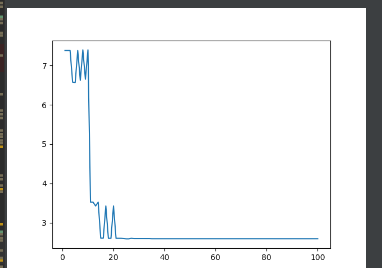

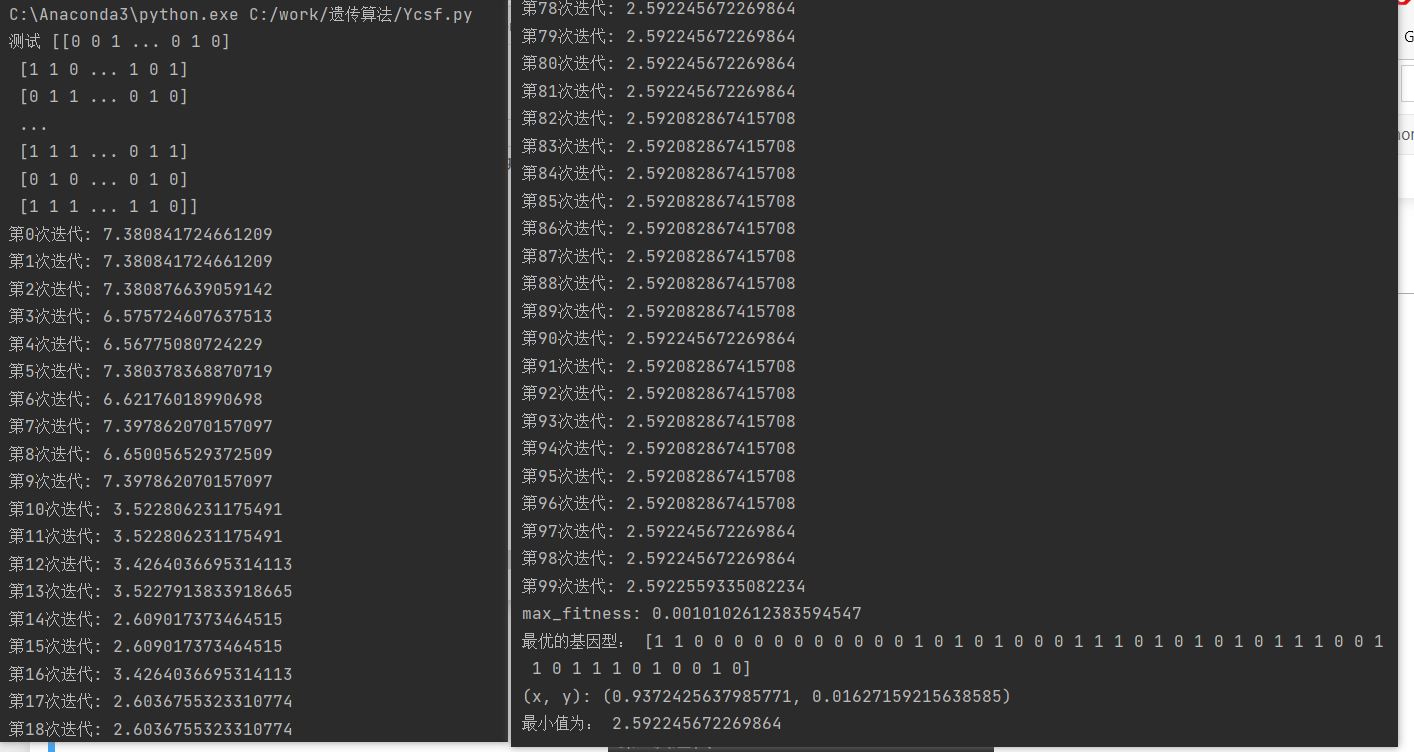